# Dynamic Aperture
*Note: This notebook will soon be refactored into a single SciBmad function for general usage*

Thanks to SciBmad's support for both explicit Single Instruction, Multiple Data (SIMD) on the CPU and Single Instruction, Multiple Thread (SIMT) on the GPU, highly-parallelized and performant tracking simulations can be run on all types of architectures. Here we will do a dynamic aperture scan of the v6.3.1 Electron Storage Ring (ESR) of the Electron-Ion Collider (EIC).

In [21]:
using SciBmad, ChangePrecision
@changeprecision Float32 include("../lattices/esr-v6.3.1-tapered.jl");

In [22]:
ring.R_ref

-59.528725f0

In [23]:
# Turn on radiation damping:
foreach(t->t.tracking_method=SciBmad.Yoshida(radiation_damping_on=true), ring.line)

# Twiss:
t = twiss(ring)

# Tunes:
t.phi_1[end], t.phi_2[end], t.phi_3[end]

(48.08009259772981, 44.140163906878634, -0.04999949235621811)

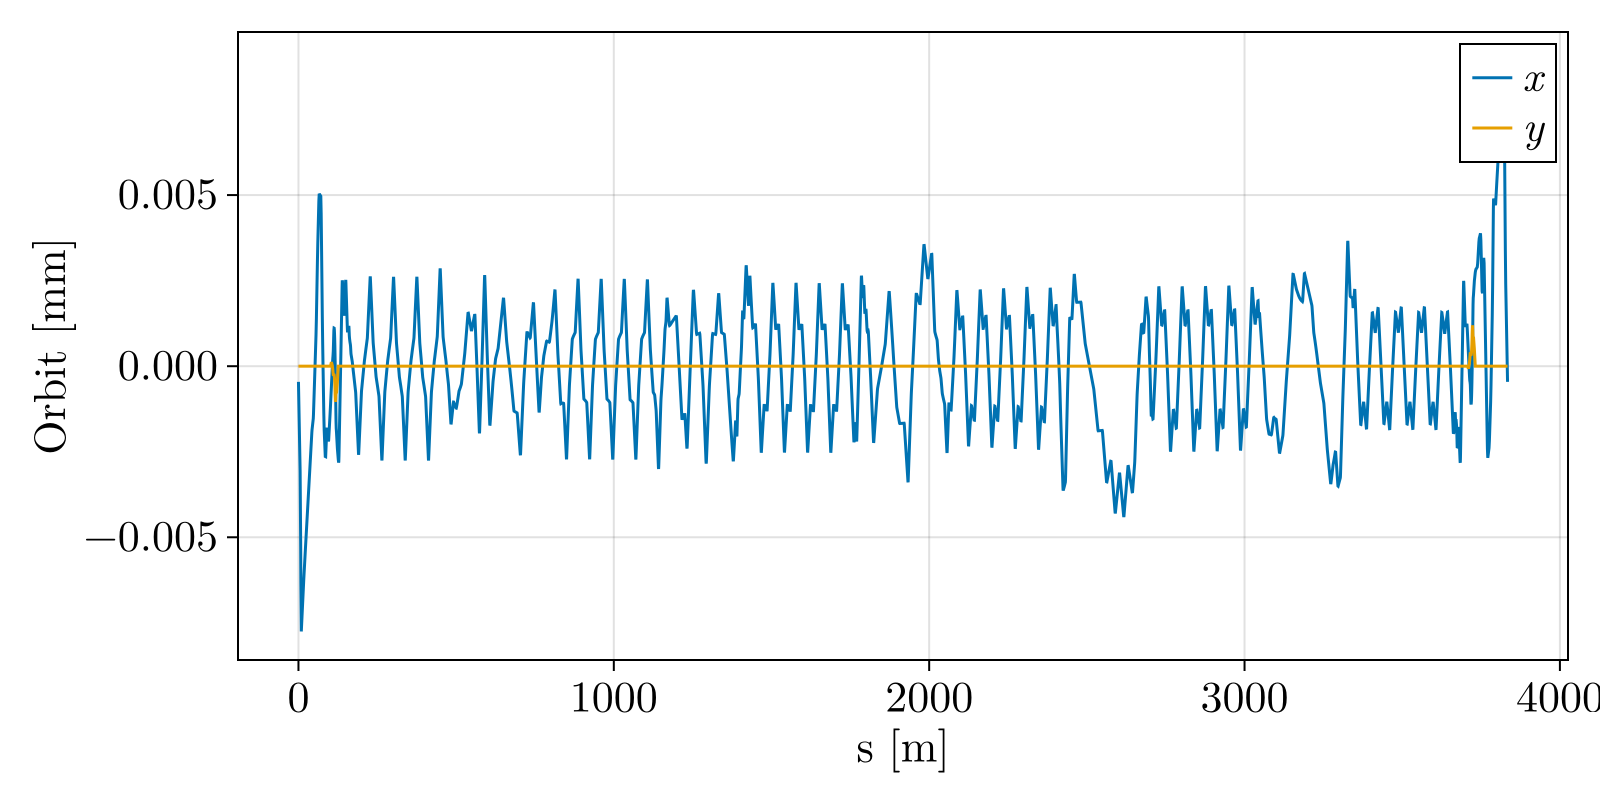

In [24]:
# Plot the orbit:
using CairoMakie
with_theme(theme_latexfonts()) do
    f = Figure(fontsize=22, size=(800,400));
    ax = Axis(f[1, 1], xlabel="s [m]", ylabel="Orbit [mm]");
    lines!(ax, t.s, t.orbit_x.*10^3, label=L"x"); 
    lines!(ax, t.s, t.orbit_y.*10^3, label=L"y");
    axislegend(position=:rt);
    display(f);
end;

In [25]:
# Now let's do DA scan. we will track a bunch and see what happens
# Using numbers from previous DA studies:
emit_a = 30e-9
emit_b = 15e-9       # Very conservative...
emit_c = 7.30474E-06 # From Bmad/PTC

7.30474e-6

In [26]:
# To compute sig_x, need to convert eigenemittances to moments
# Use de moivre:
td = twiss(ring; de_moivre=true);

In [27]:
# Now compute sigmas at first element (IP)
E = td.E[1]
sig_x = sqrt(E[1][1,1]*emit_a + E[2][1,1]*emit_b + E[3][1,1]*emit_c)
sig_y = sqrt(E[1][3,3]*emit_a + E[2][3,3]*emit_b + E[3][3,3]*emit_c)
sig_x, sig_y

(0.00013305680874184644, 2.9244005970450432e-5)

In [42]:
# Create uniform distribution for various deltas

# Initialize matrix of particles:
x_pts = (-15:0.5:15) .* sig_x
y_pts = (0:0.5:22) .* sig_y
deltas = [0.0] # tmp  # (0:0.1:1).*10^-2 # 0.1-1% delta

N_particles = length(x_pts)*length(y_pts)*length(deltas)
v = zeros(Float32, N_particles , 6)
idx_particle = 1
for delta in deltas
    for x in x_pts
        for y in y_pts
            v[idx_particle, :] = [x, 0, y, 0, 0, delta]
            idx_particle += 1
        end
    end
end
b0 = Bunch(v)
v

2745×6 Matrix{Float32}:
 -0.00199585  0.0  0.0          0.0  0.0  0.0
 -0.00199585  0.0  1.4622f-5    0.0  0.0  0.0
 -0.00199585  0.0  2.9244f-5    0.0  0.0  0.0
 -0.00199585  0.0  4.3866f-5    0.0  0.0  0.0
 -0.00199585  0.0  5.8488f-5    0.0  0.0  0.0
 -0.00199585  0.0  7.311f-5     0.0  0.0  0.0
 -0.00199585  0.0  8.7732f-5    0.0  0.0  0.0
 -0.00199585  0.0  0.000102354  0.0  0.0  0.0
 -0.00199585  0.0  0.000116976  0.0  0.0  0.0
 -0.00199585  0.0  0.000131598  0.0  0.0  0.0
 -0.00199585  0.0  0.00014622   0.0  0.0  0.0
 -0.00199585  0.0  0.000160842  0.0  0.0  0.0
 -0.00199585  0.0  0.000175464  0.0  0.0  0.0
  ⋮                                       ⋮
  0.00199585  0.0  0.000482526  0.0  0.0  0.0
  0.00199585  0.0  0.000497148  0.0  0.0  0.0
  0.00199585  0.0  0.00051177   0.0  0.0  0.0
  0.00199585  0.0  0.000526392  0.0  0.0  0.0
  0.00199585  0.0  0.000541014  0.0  0.0  0.0
  0.00199585  0.0  0.000555636  0.0  0.0  0.0
  0.00199585  0.0  0.000570258  0.0  0.0  0.0
  0.00199585

In [47]:
# Now track!
foreach(t->t.tracking_method=SciBmad.Yoshida(radiation_damping_on=true, radiation_fluctuations_on=true), ring.line)
@time begin
N_turns = 1
for _ in 1:N_turns
    track!(b0, ring; use_KA=true)
end
end
#findlast(t->t==0x01, b0.coords.state)
#const KA = SciBmad.BeamTracking.KernelAbstractions

LoadError: TaskFailedException

[91m    nested task error: [39mDomainError with -7.774656373751805e6:
    sqrt was called with a negative real argument but will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).
    Stacktrace:
      [1] [0m[1mthrow_complex_domainerror[22m[0m[1m([22m[90mf[39m::[0mSymbol, [90mx[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [90mBase.Math[39m [90m./[39m[90m[4mmath.jl:33[24m[39m
      [2] [0m[1msqrt[22m
    [90m    @[39m [90m./[39m[90m[4mmath.jl:686[24m[39m[90m [inlined][39m
      [3] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/.julia/dev/BeamTracking/src/kernels/[39m[90m[4mradiation.jl:160[24m[39m[90m [inlined][39m
      [4] [0m[1mstochastic_radiation![22m
    [90m    @[39m [90m~/.julia/dev/BeamTracking/src/[39m[90m[4mkernel.jl:209[24m[39m[90m [inlined][39m
      [5] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/.julia/dev/BeamTracking/src/kernels/[39m[90m[4myoshida.jl:39[24m[39m[90m [inlined][39m
      [6] [0m[1morder_four_integrator![22m
    [90m    @[39m [90m~/.julia/dev/BeamTracking/src/[39m[90m[4mkernel.jl:209[24m[39m[90m [inlined][39m
      [7] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/.julia/packages/Unrolled/KtWta/src/[39m[90m[4mUnrolled.jl:47[24m[39m[90m [inlined][39m
      [8] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/.julia/dev/BeamTracking/src/[39m[90m[4mkernel.jl:57[24m[39m[90m [inlined][39m
      [9] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/.julia/packages/Unrolled/KtWta/src/[39m[90m[4mUnrolled.jl:127[24m[39m[90m [inlined][39m
     [10] [0m[1m__generic_kernel![22m[0m[1m([22m[90mi[39m::[0mInt64, [90mcoords[39m::[0mBeamTracking.Coords[90m{Vector{UInt8}, Matrix{Float32}, Nothing}[39m, [90mchain[39m::[0mTuple[90m{BeamTracking.KernelCall{typeof(BeamTracking.order_four_integrator!), Tuple{typeof(BeamTracking.mkm_quadrupole!), Tuple{Float64, Float64, Bool, Float64, Float64, Float64, Float64, StaticArraysCore.SVector{4, Float64}, StaticArraysCore.SVector{4, Float64}, Float64, StaticArraysCore.SVector{1, Int64}, StaticArraysCore.SVector{1, Float64}, StaticArraysCore.SVector{1, Float64}}, Tuple{Float64, Float64, Float64, Int64, Int64, StaticArraysCore.SVector{1, Int64}, StaticArraysCore.SVector{1, Float64}, StaticArraysCore.SVector{1, Float64}}, Float32, Int64, Int64, Int64, Float32}}, Vararg{BeamTracking.KernelCall{typeof(BeamTracking.blank_kernel!), Tuple{}}, 5}}[39m, [90mref[39m::[0mBeamTracking.RefState[90m{Float64, Float64}[39m[0m[1m)[22m
    [90m    @[39m [35mBeamTracking[39m [90m~/.julia/packages/Unrolled/KtWta/src/[39m[90m[4mUnrolled.jl:127[24m[39m
     [11] [0m[1m_generic_kernel![22m
    [90m    @[39m [90m~/.julia/dev/BeamTracking/src/[39m[90m[4mkernel.jl:54[24m[39m[90m [inlined][39m
     [12] [0m[1mcpu_generic_kernel![22m
    [90m    @[39m [90m~/.julia/packages/KernelAbstractions/X5fk1/src/[39m[90m[4mmacros.jl:314[24m[39m[90m [inlined][39m
     [13] [0m[1m__thread_run[22m[0m[1m([22m[90mtid[39m::[0mInt64, [90mlen[39m::[0mInt64, [90mrem[39m::[0mInt64, [90mobj[39m::[0mKernelAbstractions.Kernel[90m{KernelAbstractions.CPU, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, typeof(BeamTracking.cpu_generic_kernel!)}[39m, [90mndrange[39m::[0mTuple[90m{Int64}[39m, [90miterspace[39m::[0mKernelAbstractions.NDIteration.NDRange[90m{1, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}}[39m, [90margs[39m::[0mTuple[90m{BeamTracking.Coords{Vector{UInt8}, Matrix{Float32}, Nothing}, BeamTracking.KernelChain{Tuple{BeamTracking.KernelCall{typeof(BeamTracking.order_four_integrator!), Tuple{typeof(BeamTracking.mkm_quadrupole!), Tuple{Float64, Float64, Bool, Float64, Float64, Float64, Float64, StaticArraysCore.SVector{4, Float64}, StaticArraysCore.SVector{4, Float64}, Float64, StaticArraysCore.SVector{1, Int64}, StaticArraysCore.SVector{1, Float64}, StaticArraysCore.SVector{1, Float64}}, Tuple{Float64, Float64, Float64, Int64, Int64, StaticArraysCore.SVector{1, Int64}, StaticArraysCore.SVector{1, Float64}, StaticArraysCore.SVector{1, Float64}}, Float32, Int64, Int64, Int64, Float32}}, Vararg{BeamTracking.KernelCall{typeof(BeamTracking.blank_kernel!), Tuple{}}, 5}}, BeamTracking.RefState{Float64, Float64}}}[39m, [90mdynamic[39m::[0mKernelAbstractions.NDIteration.DynamicCheck[0m[1m)[22m
    [90m    @[39m [35mKernelAbstractions[39m [90m~/.julia/packages/KernelAbstractions/X5fk1/src/[39m[90m[4mcpu.jl:145[24m[39m
     [14] [0m[1m(::KernelAbstractions.var"#29#32"{KernelAbstractions.Kernel{KernelAbstractions.CPU, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, typeof(BeamTracking.cpu_generic_kernel!)}, Tuple{Int64}, KernelAbstractions.NDIteration.NDRange{1, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}}, Tuple{BeamTracking.Coords{Vector{UInt8}, Matrix{Float32}, Nothing}, BeamTracking.KernelChain{Tuple{BeamTracking.KernelCall{typeof(BeamTracking.order_four_integrator!), Tuple{typeof(BeamTracking.mkm_quadrupole!), Tuple{Float64, Float64, Bool, Float64, Float64, Float64, Float64, StaticArraysCore.SVector{4, Float64}, StaticArraysCore.SVector{4, Float64}, Float64, StaticArraysCore.SVector{1, Int64}, StaticArraysCore.SVector{1, Float64}, StaticArraysCore.SVector{1, Float64}}, Tuple{Float64, Float64, Float64, Int64, Int64, StaticArraysCore.SVector{1, Int64}, StaticArraysCore.SVector{1, Float64}, StaticArraysCore.SVector{1, Float64}}, Float32, Int64, Int64, Int64, Float32}}, Vararg{BeamTracking.KernelCall{typeof(BeamTracking.blank_kernel!), Tuple{}}, 5}}, BeamTracking.RefState{Float64, Float64}}}, KernelAbstractions.NDIteration.DynamicCheck, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [35mKernelAbstractions[39m [90m~/.julia/packages/KernelAbstractions/X5fk1/src/[39m[90m[4mcpu.jl:120[24m[39m

In [312]:
# 30 seconds for 50 turns
# rate is 30/50 seconds per turn
30/50*2000/60 # will take 20 minutes for 2000 turns
# assuming linear scaling,  too long...
# need to move to GPU

20.0

In [10]:
N_particles

2745

In [320]:
2*2000/60

66.66666666666667

In [12]:
Float32.([1.,2.,3.])

3-element Vector{Float32}:
 1.0
 2.0
 3.0